In [1]:
# basic_detector.ipynb
# Authors: Stephan Meighen-Berger
# An (over-)simplified detector simulation chain

In [2]:
# imports
# General imports
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from scipy.ndimage import gaussian_filter
from tqdm.auto import tqdm
# Some custom stuff
from fennel import Fennel

Make sure your code is using a reproducible random number generator

In [3]:
# random state seed
rng = np.random.RandomState(1337)

Some constants

In [4]:
c_water = 225000 * 1e5

Loading atmospheric neutrino fluxes. these were pre-simulated using [MCEq](https://github.com/mceq-project/MCEq)

In [5]:
# Injected flux
energy_bins = np.logspace(np.log10(0.07943282347242814), 11, 122)  # in GeV (this is the grid MCEq uses)
energy_grid = np.sqrt(energy_bins[1:] * energy_bins[:-1])
energy_widths = (energy_bins[1:] + energy_bins[:-1]) / 2

path_to_data = '../data/'
with open(path_to_data + 'mceq_numu_grid.pkl', 'rb') as handle:
    numu_flux = pkl.load(handle)  # In (GeV cm^2 s sr)^{-1}

with open(path_to_data + 'mceq_nue_grid.pkl', 'rb') as handle:
    nue_flux = pkl.load(handle)  # In (GeV cm^2 s sr)^{-1}

Let's plot the fluxes and see what we're working with

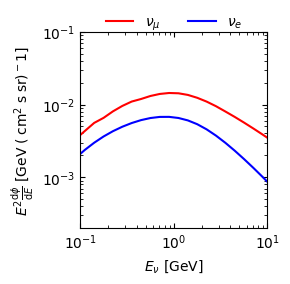

In [6]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

mag = 2

ax.plot(
    energy_grid,
    numu_flux * energy_grid**mag,
    color='r',
    ls='-',
    label=r'$\nu_\mu$'

)

ax.plot(
    energy_grid,
    nue_flux * energy_grid**mag,
    color='b',
    ls='-',
    label=r'$\nu_e$'
)
# -----------------------------------------------------------
# axis
ax.set_xlim(1e-1, 1e1)
ax.set_ylim(2e-4, 1e-1)
ax.set_yscale('log')
ax.set_xscale('log')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=3, loc=9, bbox_to_anchor=(0.5, 1.15))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.set_ylabel(r"$E^2\frac{\mathrm{d}\phi}{\mathrm{d}E}\;\mathrm{[ GeV\;(\;cm^2\;s\;sr)^-1]}$")
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Some simplified cross sections. For a true simulation you would either be using [GENIE](https://hep.ph.liv.ac.uk/~costasa/genie/index.html) or [LeptonInjector](https://github.com/icecube/LeptonInjector) or something similar.
The cross sections here are not physical.

#### Exercise 1
Implement more realistic cross sections. Either by using the total cross section, or using differential cross sections depending on the outgoing particles

In [7]:
# The injection
def cross_section_CC(E: np.ndarray, scale=1e-38) -> np.ndarray:
    """ Oversimplified neutrino cross section

    Parameters
    ----------
    E: np.ndarray
        The energies of interest in GeV

    scale: float
        Optional: The scale of the cross section at 1 GeV
    """
    return scale * np.sqrt(E)

def cross_section_NC(E: np.ndarray, scale=1e-38) -> np.ndarray:
    """ Oversimplified neutrino cross section

    Parameters
    ----------
    E: np.ndarray
        The energies of interest in GeV

    scale: float
        Optional: The scale of the cross section at 1 GeV
    """
    return cross_section_CC(E, scale=scale) * 1./3.

Our detector is a simple sphere with radius 10 m and filled with water. Currently we are assuming the outer wall is completely covered by PMT's with 100% efficiency. More on that later

In [8]:
# The detector
demo_sphere_radius = 10 * 1e2  # in cm
volume_detector = demo_sphere_radius**3 * 4 / 3 * np.pi

For simplicity we are using [Fennel](https://github.com/MeighenBergerS/fennel/tree/master) a parametrized approximation of light-production from charged particles (focus on Cherenkov light) based on GEANT4.

#### Exercise 2

Create your own light-yield tables using GEANT4. To that end you need to inject different (charged) particles into a large block of water and track their light-production. Note this requires you to implement your own Cherenkov production code!

In [9]:
# Light-yields and propagation
# Here we are creating a basic Fennel instance
fl = Fennel()

Running fennel and creating some tables. Here we are assuming 2 types of charged particles: $e^-$ and $\pi$. $\pi$ will take the place of hadronic cascades. Note, that CC $\nu_e$ events also create hadronic cascades. Here we are neglecting those. Additonally, we are ignoring multiple $\pi$, $p$, $n$ etc.

In [10]:
# Basic grids and the different distributions we will need
z_grid = np.linspace(0, 1e4, int(1e4 / 23))  # Weird number due to speed of light in water and timing used later
wavelengths = np.linspace(350., 500., 100)
dc_em, dc_sample_em, _, _, zp_em, _ = fl.auto_yields(1e1, 11, z_grid=z_grid, wavelengths=wavelengths)
dc_had, dc_sample_had, _, _, zp_had, _ = fl.auto_yields(1e1, 211, z_grid=z_grid, wavelengths=wavelengths)

In [11]:
# Total photon counts
# Integrating the differential distributions
em_counts = np.trapz(dc_em, wavelengths)
had_counts = np.trapz(dc_had, wavelengths)

A plot of the light yields from $e^-$ and $\pi^-$. Note, the differences in the distribution. This is what we will be using later.

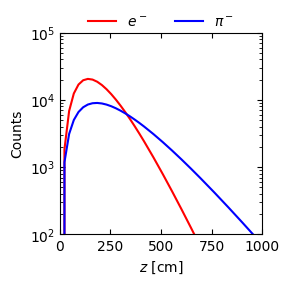

In [12]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(
    z_grid,
    zp_em[0] / np.trapz(zp_em[0], x=z_grid) * em_counts,
    color='r',
    ls='-',
    label=r'$e^-$'
)

ax.plot(
    z_grid,
    zp_had[0] / np.trapz(zp_had[0], x=z_grid) * had_counts,
    color='b',
    ls='-',
    label=r'$\pi^-$'
)
# -----------------------------------------------------------
# axis
ax.set_xlim(0, 1e3)
ax.set_ylim(1e2, 1e5)
ax.set_yscale('log')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=3, loc=9, bbox_to_anchor=(0.5, 1.15))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$z$ [cm]")
ax.set_ylabel(r"Counts")
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Here we are approximating the spatial distribution of events by uniformly sampling the detector volume.

In [13]:
# Sampling function for the interaction
def spatial_sampling(nsamples: int, detector_radius: float, rng: np.random.RandomState) -> np.ndarray:
    """ generates an event sample

    Parameters
    ----------
    nsamples: int
        Number of samples
    detector_radius: float
        The radius of the detector
    rng: np.random.RandomState
        The random state generator

    Returns
    -------
    rsamples: np.ndarray
        Sampled radius
    phi_samples: np.ndarray
        Sampled phi (interaction point and outgoing)
    theta_samples: np.ndarray
        Sampled theta (interaction point and outgoing)
    """
    radius_samples = rng.uniform(0, detector_radius, size=nsamples)
    phi_samples = rng.uniform(0., 360., size=(nsamples, 2))
    theta_samples = rng.uniform(0., 180., size=(nsamples, 2))
    return radius_samples, phi_samples, theta_samples

In [14]:
# Resulting sample for 50 events
rsampl, phisamp, thetasampl = spatial_sampling(50, demo_sphere_radius, rng)

A plot showing the output of the sampling. For the example here, we need the starting position and direction of the particle.

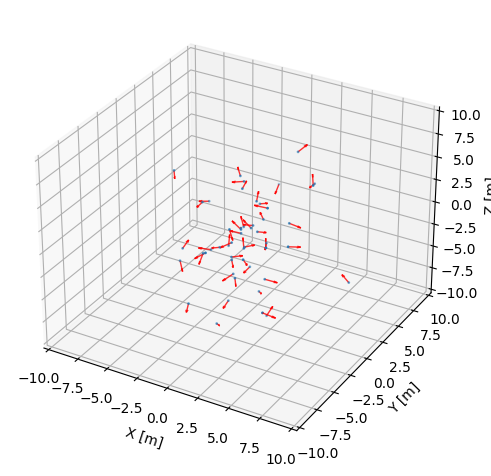

In [15]:
# Let's plot it
# -----------------------------------------------------------
# plot

theta, phi = np.linspace(0, 2 * np.pi, 40), np.linspace(0, np.pi, 40)
THETA, PHI = np.meshgrid(theta, phi)
R = np.cos(PHI**2)
X_int = rsampl * np.sin(phisamp[:, 0]) * np.cos(thetasampl[:, 0])
Y_int = rsampl * np.sin(phisamp[:, 0]) * np.sin(thetasampl[:, 0])
Z_int = rsampl * np.cos(phisamp[:, 0])

arrow_scale = 1

X_dir = arrow_scale * np.sin(phisamp[:, 1]) * np.cos(thetasampl[:, 1])
Y_dir = arrow_scale * np.sin(phisamp[:, 1]) * np.sin(thetasampl[:, 1])
Z_dir = arrow_scale * np.cos(phisamp[:, 1])
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(
    X_int / 1e2, Y_int / 1e2, Z_int / 1e2, s=1
)

for idevent, _ in enumerate(rsampl):
    #ax.plot([mean_x,v[0]], [mean_y,v[1]], [mean_z,v[2]], color='red', alpha=0.8, lw=3)
    #I will replace this line with:
    ax.quiver(
        X_int[idevent] / 1e2, Y_int[idevent] / 1e2, Z_int[idevent] / 1e2,
        X_dir[idevent], Y_dir[idevent], Z_dir[idevent],
        color = 'red', alpha = .8, lw = 1
        )
# -----------------------------------------------------------
# axis
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"X [m]")
ax.set_ylabel(r"Y [m]")
ax.set_zlabel(r"Z [m]")
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Some additional simulation parameters. In the analysis chain, these should be input parameters set by the user e.g. via a config file.

In [16]:
#  simulation parameters
year = 365 * 24 * 60 * 60
time = 10 * year
molecules_per_cm3 = 3.345 * 10**22
molecules_detector = molecules_per_cm3 * volume_detector
nTargets = (16 + 2) * molecules_detector  # H2O

detector_factor = nTargets * time * np.pi * 4

Here we are approximating the event rate via the equation I made fun of

In [17]:
interactions_numu_nc = detector_factor * numu_flux * cross_section_NC(energy_grid) * energy_widths
interactions_nue_CC = detector_factor * nue_flux * cross_section_CC(energy_grid) * energy_widths
interactions_nue_NC = detector_factor * nue_flux * cross_section_NC(energy_grid) * energy_widths

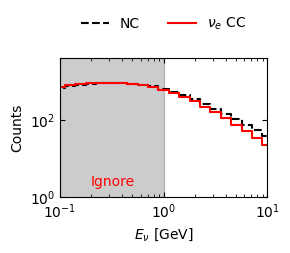

In [18]:
# A plot of the expected event rates.
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

mag = 2

ax.step(
    energy_grid,
    interactions_numu_nc + interactions_nue_NC,
    color='k',
    ls='--',
    label=r'NC'

)

ax.step(
    energy_grid,
    interactions_nue_CC,
    color='r',
    ls='-',
    label=r'$\nu_e$ CC'

)

ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
ax.set_xlim(1e-1, 1e1)
ax.set_ylim(1e0, 4e3)
ax.set_yscale('log')
ax.set_xscale('log')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.4))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.set_ylabel(r"Counts")
ax.text(2e-1, 2, "Ignore", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Let's cut the energy range. Note, that the NC event rate lies above the CC $\nu_e$ event rate. While this is good enough to statistically measure the CC events, we want to do better and show the usefulness of a detector simulation.

#### Exercise 3

Calculate/estimate the significance of the NC events assuming a 20% uncertainty on the cross section (-> event rate) for both NC and CC events.

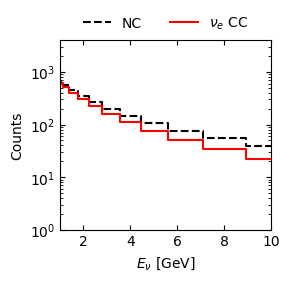

In [19]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.step(
    energy_grid,
    interactions_numu_nc + interactions_nue_NC,
    color='k',
    ls='--',
    label=r'NC'

)

ax.step(
    energy_grid,
    interactions_nue_CC,
    color='r',
    ls='-',
    label=r'$\nu_e$ CC'

)

# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e0, 4e3)
ax.set_yscale('log')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.2))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.set_ylabel(r"Counts")
# ax.text(2e-1, 2, "Ignore", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Let's do better. For that we need to figure out how (and if) our detector can distinguish between NC and CC events. This means we need to calculate the detector response.

In [20]:
# Quick and dirty helper function
# This is missing documentation!
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Let's calculate the shower length for $e^-1$ and $\pi$. Let's assume our detector can see 100 $\gamma$ per cm. In reality one would need to simulate each produced photon and track whether they hit a PMT or not. Then sample via the QE (quantum efficiency) of the PMT. You'd also need to account for angular acceptance, attenuation, and scattering in the water.

In [21]:
# Quick and dirty estimation of the shower lengths

electron_photons = []
hadron_photons = []
em_lengths = []
had_lengths = []

photon_cut = 100

for E in energy_grid:
    dc_em, dc_sample_em, _, _, zp_em, _ = fl.auto_yields(E, 11, z_grid=z_grid, wavelengths=wavelengths)
    dc_had, dc_sample_had, _, _, zp_had, _ = fl.auto_yields(E, 211, z_grid=z_grid, wavelengths=wavelengths)
    em_counts = np.trapz(dc_em, wavelengths)
    had_counts = np.trapz(dc_had, wavelengths)
    em_tmp  = zp_em[0] / np.trapz(zp_em[0], x=z_grid) * em_counts
    had_tmp = zp_had[0] / np.trapz(zp_had[0], x=z_grid) * had_counts
    em_lengths.append(z_grid[find_nearest(em_tmp, photon_cut)])
    had_lengths.append(z_grid[find_nearest(had_tmp, photon_cut)])
    electron_photons.append(zp_em[0] / np.trapz(zp_em[0], x=z_grid) * em_counts)
    hadron_photons.append(zp_had[0] / np.trapz(zp_had[0], x=z_grid) * had_counts)

had_lengths = np.array(had_lengths)[10:22]
em_lengths = np.array(em_lengths)[10:22]

electron_photons = np.array(electron_photons)[10:22]
hadron_photons = np.array(hadron_photons)[10:22]

/home/unimelb.edu.au/smeighenberg/envs/erebus/lib/python3.10/site-packages/fennel/em_cascades.py:149: RuntimeWarning: divide by zero encountered in power
  (t * b)**(a_val - 1.) * np.exp(-(t*b)) / gamma_func(a_val)
/home/unimelb.edu.au/smeighenberg/envs/erebus/lib/python3.10/site-packages/fennel/hadron_cascades.py:184: RuntimeWarning: invalid value encountered in double_scalars
  em_fraction_sd = sigma0 * np.log(E)**(-gamma)
/home/unimelb.edu.au/smeighenberg/envs/erebus/lib/python3.10/site-packages/fennel/hadron_cascades.py:220: RuntimeWarning: divide by zero encountered in power
  (t * b)**(a_val - 1.) * np.exp(-(t*b)) / gamma_func(a_val)
/home/unimelb.edu.au/smeighenberg/envs/erebus/lib/python3.10/site-packages/fennel/hadron_cascades.py:359: RuntimeWarning: invalid value encountered in double_scalars
  a = a_pars[0] * (np.log(E))**a_pars[1]
/home/unimelb.edu.au/smeighenberg/envs/erebus/lib/python3.10/site-packages/fennel/hadron_cascades.py:360: RuntimeWarning: invalid value encounter

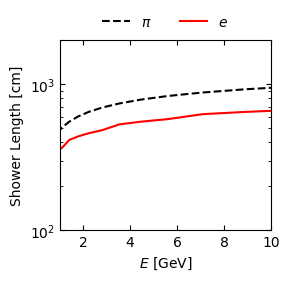

In [22]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.plot(
    energy_grid[10:22],
    had_lengths,
    color='k',
    ls='--',
    label=r'$\pi$'

)

ax.plot(
    energy_grid[10:22],
    em_lengths,
    color='r',
    ls='-',
    label=r'$e$'

)

# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e2, 2e3)
ax.set_yscale('log')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.2))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$E$ [GeV]")
ax.set_ylabel(r"Shower Length [cm]")
# ax.text(2e-1, 2, "Ignore", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Right, now we have all the pieces to write a (very rough) event generator for our detector. Note that here we are neglecting the shape of the Cherenkov emission

In [23]:
ns_bins = np.linspace(0, 100, 101)

def event_generator(
        nsamples: np.ndarray,
        detector_radius: float,
        rng: np.random.RandomState,
        type='CC') -> np.ndarray:
    """ generates particle events within the detector

    Paremeters
    ----------
    nsamples: np.array
        The binned expected event rate per energy.
    detector_radius: float
        The radius of the detector can be changed but should align with the plugged
        in event rate
    rng: np.random.RandomState
        The random number generator. This allows for reproducibility
    type: str
        Optional: The event type to generate

    Returns
    -------
    timing: np.array
        The photon hits for each event distributed in ns
    """
    # Spatial generation
    spatial_samples = []
    for nsamp in nsamples:
        spatial_samples.append(
            spatial_sampling(int(nsamp), detector_radius, rng)
        )
    # Which distributions to use
    if type == 'CC':
        lengths = em_lengths
        distro = electron_photons
    else:
        lengths = had_lengths
        distro = hadron_photons
    spatial_cuts = []
    timing_arr = []
    # Later we are going to remove not fully contained events.
    for idE, spatial_sample in enumerate(spatial_samples):
        rsampl, phisamp, thetasampl = spatial_sample
        X_int = rsampl * np.sin(phisamp[:, 0]) * np.cos(thetasampl[:, 0])
        Y_int = rsampl * np.sin(phisamp[:, 0]) * np.sin(thetasampl[:, 0])
        Z_int = rsampl * np.cos(phisamp[:, 0])
        arrow_scale = lengths[idE]
        X_dir = arrow_scale * np.sin(phisamp[:, 1]) * np.cos(thetasampl[:, 1])
        Y_dir = arrow_scale * np.sin(phisamp[:, 1]) * np.sin(thetasampl[:, 1])
        Z_dir = arrow_scale * np.cos(phisamp[:, 1])
        # Spatial Cuts
        event_r = np.sqrt(
            (X_int + X_dir)**2 +
            (Y_int + Y_dir)**2 +
            (Z_int + Z_dir)**2
        )
        # Boolean for spatial cuts used later
        event_cut = event_r < detector_radius
        spatial_cuts.append(event_cut)
        # Timing
        energy_sample = []
        for idS, _ in enumerate(X_int):
            hits_binned, _ = np.histogram(
                ((np.abs(event_r[idS] - detector_radius) + z_grid) / c_water) * 1e9,
                bins=ns_bins, weights=distro[idE]
            )
            energy_sample.append(gaussian_filter(hits_binned, sigma=2, radius=10))
        timing_arr.append(energy_sample)
    spatial_cuts = np.array(spatial_cuts)
    return spatial_samples, np.array(timing_arr), spatial_cuts

A proper event generator would not have cuts placed within. What you would usually output is the event and the photon hits + the "MC truth" aka. where the particle was produced, which direction, emitted photons, and track.

#### Exercise 4

Generate $\nu_\mu$ CC events.

In [24]:
# Generating NC and CC events

spatial_samples_CC, timing_samples_CC, cuts_CC = event_generator(
    interactions_nue_CC[10:22],
    demo_sphere_radius,
    rng,
    type='CC'
)

spatial_samples_NC, timing_samples_NC, cuts_NC = event_generator(
    (interactions_numu_nc + interactions_nue_NC)[10:22],
    demo_sphere_radius,
    rng,
    type='NC'
)

TypeError: event_generator() got multiple values for argument 'type'

In [ ]:
# Total counts
CC_counts = np.array([
    np.sum(cut_e) for cut_e in cuts_CC
])
NC_counts = np.array([
    np.sum(cut_e) for cut_e in cuts_NC
])

Below we plot the photon hit distribution of a single event.

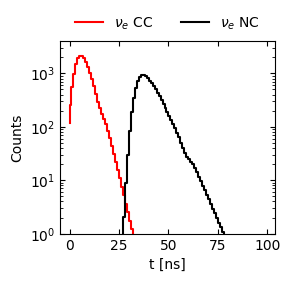

In [ ]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.step(
    ns_bins[:-1], timing_samples_CC[0][121],
    color='r',
    ls='-',
    label=r'$\nu_e$ CC'

)

ax.step(
    ns_bins[:-1], timing_samples_NC[0][30],
    color='k',
    ls='-',
    label=r'$\nu_e$ NC'

)
# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
# ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e0, 4e3)
ax.set_yscale('log')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.2))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"t [ns]")
ax.set_ylabel(r"Counts")
# ax.text(2e-1, 2, "Ignore", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

A comparison plot of fully contained events and the total event rate.

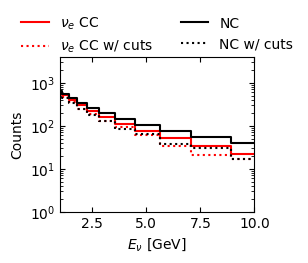

In [ ]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.step(
    energy_grid[10:22],
    interactions_nue_CC[10:22],
    color='r',
    ls='-',
    label=r'$\nu_e$ CC'

)

ax.step(
    energy_grid[10:22],
    CC_counts,
    color='r',
    ls=':',
    label=r'$\nu_e$ CC w/ cuts'

)

ax.step(
    energy_grid,
    interactions_numu_nc + interactions_nue_NC,
    color='k',
    ls='-',
    label=r'NC'

)

ax.step(
    energy_grid[10:22],
    NC_counts,
    color='k',
    ls=':',
    label=r'NC w/ cuts'

)

# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e0, 4e3)
ax.set_yscale('log')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.35))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.set_ylabel(r"Counts")
# ax.text(2e-1, 2, "Ignore", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

Let's see how the distributions look for all CC vs NC events

#### Exercise 5
Come up with your own selection criteria using the timing distributions. Here we are comparing the distribution ratios pre and after the maximal light yield.

In [ ]:
# Analysis
def tail_vs_start(pulses: np.ndarray) -> np.ndarray:
    """ takes an array of pulses and checks their likelihood of being a CC event
    """
    idmaxes = np.argmax(pulses, axis=1)
    ratio_arr = np.array([
        np.sum(pulses[idTest][idmaxes[idTest]+1:]) /
        np.sum(pulses[idTest][:idmaxes[idTest]+1])
        for idTest in range(len(pulses))
    ])
    return ratio_arr

def data_TvsS_test(all_pulses: np.ndarray, cuts:np.ndarray) -> np.ndarray:
    """ helper function to apply analysis to the entire set
    """
    ratio_energy_bins = []
    for idE, energy_bin in enumerate(all_pulses):
        tmp_pulses = np.array(energy_bin)[cuts[idE]]
        ratio_energy_bins.append(tail_vs_start(tmp_pulses))
    return np.concatenate(np.array(ratio_energy_bins, dtype=object))

def data_TvsS_cut(all_pulses: np.ndarray, cuts:np.ndarray, TvsS_cut: float) -> np.ndarray:
    """ helper function to apply analysis cuts to the entire set
    """
    tmp_bool = []
    for idE, energy_bin in enumerate(all_pulses):
        tmp_pulses = np.array(energy_bin)[cuts[idE]]
        tmp_bool.append(np.less(tail_vs_start(tmp_pulses), TvsS_cut))
    return np.array(tmp_bool, dtype=object)

In [ ]:
# The different ratios
cc_ratios = data_TvsS_test(timing_samples_CC, cuts_CC)
nc_ratios = data_TvsS_test(timing_samples_NC, cuts_NC)

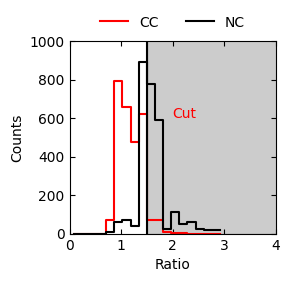

In [ ]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

tmp_bins = np.linspace(0, 3, 20)
tmp_centers = (tmp_bins[1:] + tmp_bins[:-1]) / 2

cc_binned, _ = np.histogram(cc_ratios, bins=tmp_bins)
nc_binned, _ = np.histogram(nc_ratios, bins=tmp_bins)

ax.step(
    tmp_centers,
    cc_binned,
    color='r',
    ls='-',
    label=r'CC'
)

ax.step(
    tmp_centers,
    nc_binned,
    color='k',
    ls='-',
    label=r'NC'
)

ax.axvline(np.percentile(nc_ratios, 10), 0, 1e4, color='k')
ax.fill_betweenx([0, 1e4], np.percentile(nc_ratios, 10), 5, color='k', alpha=0.2)

# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
ax.set_xlim(0, 4)
ax.set_ylim(0, 1e3)
ax.set_yscale('linear')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.2))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"Ratio")
ax.set_ylabel(r"Counts")
ax.text(2, 600, "Cut", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

This number is what we can use to cut 90% of the NC events

#### Exercise 6
Try to find what the cut should be to maximize the significance of the final analysis

In [ ]:
np.percentile(nc_ratios, 10)

1.5023669629595957

In [ ]:
cc_cut_set = data_TvsS_cut(timing_samples_CC, cuts_CC, 1.5023693639498166)
nc_cut_set = data_TvsS_cut(timing_samples_NC, cuts_NC, 1.5023693639498166)

# Sum didn't work
cc_cut_counts = np.array([
    np.sum(elem) for elem in cc_cut_set
])
nc_cut_counts = np.array([
    np.sum(elem) for elem in nc_cut_set
])

This is the resulting event rate after cuts

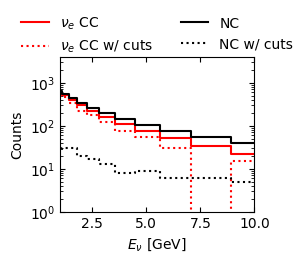

In [ ]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

ax.step(
    energy_grid[10:22],
    interactions_nue_CC[10:22],
    color='r',
    ls='-',
    label=r'$\nu_e$ CC'

)

ax.step(
    energy_grid[10:22],
    cc_cut_counts,
    color='r',
    ls=':',
    label=r'$\nu_e$ CC w/ cuts'

)

ax.step(
    energy_grid,
    interactions_numu_nc + interactions_nue_NC,
    color='k',
    ls='-',
    label=r'NC'

)

ax.step(
    energy_grid[10:22],
    nc_cut_counts,
    color='k',
    ls=':',
    label=r'NC w/ cuts'

)

# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e0, 4e3)
ax.set_yscale('log')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.35))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"$E_\nu$ [GeV]")
ax.set_ylabel(r"Counts")
# ax.text(2e-1, 2, "Ignore", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

This of course was a single simulation. For a true anaylsis you'll need to run multiple "trials". To this end, let's package all of it together and run some trials.

#### Exercise 7

Which parts here do not belong in the detector simulation chain? What represents our "detector" sim?

In [ ]:
interactions_numu_nc = detector_factor * numu_flux * cross_section_NC(energy_grid) * energy_widths
interactions_nue_CC = detector_factor * nue_flux * cross_section_CC(energy_grid) * energy_widths
interactions_nue_NC = detector_factor * nue_flux * cross_section_NC(energy_grid) * energy_widths

def analysis_simulation(nTrials: int, signal: np.ndarray, background: np.ndarray, seed=1337) -> np.ndarray:
    """ entire analysis multiple times
    """
    totals_CC_pre = []
    totals_NC_pre = []
    totals_CC = []
    totals_NC = []
    rng_trial = np.random.RandomState(seed)
    # Offloading some random number work before loop
    signal_sets = rng_trial.poisson(signal[10:22], size=(nTrials, len(signal[10:22])))
    background_sets = rng_trial.poisson(background[10:22], size=(nTrials, len(signal[10:22])))
    for set in tqdm(range(nTrials)):
        _, timing_samples_CC, cuts_CC = event_generator(
            signal_sets[set],  # Sampling the events as well!
            demo_sphere_radius,
            rng_trial,
            type='CC'
        )
        _, timing_samples_NC, cuts_NC = event_generator(
            background_sets[set],
            demo_sphere_radius,
            rng_trial,
            type='NC'
        )
        CC_counts = np.array([
            np.sum(cut_e) for cut_e in cuts_CC
        ])
        NC_counts = np.array([
            np.sum(cut_e) for cut_e in cuts_NC
        ])
        cc_cut_set = data_TvsS_cut(timing_samples_CC, cuts_CC, 1.5023693639498166)
        nc_cut_set = data_TvsS_cut(timing_samples_NC, cuts_NC, 1.5023693639498166)

        # Sum didn't work
        cc_cut_counts = np.array([
            np.sum(elem) for elem in cc_cut_set
        ])
        nc_cut_counts = np.array([
            np.sum(elem) for elem in nc_cut_set
        ])
        totals_CC_pre.append(np.sum(CC_counts))
        totals_NC_pre.append(np.sum(NC_counts))
        totals_CC.append(np.sum(cc_cut_counts))
        totals_NC.append(np.sum(nc_cut_counts))
    return np.array([
        totals_NC, totals_NC_pre,
        totals_CC, totals_CC_pre,
    ])

In [ ]:
# Generating trial
results = analysis_simulation(100, interactions_nue_CC, (interactions_numu_nc + interactions_nue_NC))

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_96558/3501186500.py:52: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spatial_cuts = np.array(spatial_cuts)
/tmp/ipykernel_96558/3501186500.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return spatial_samples, np.array(timing_arr), spatial_cuts


These are the resulting NC and CC event rates across the trials.

#### Exercise 8
Calculate the significance of the CC events using the trials.

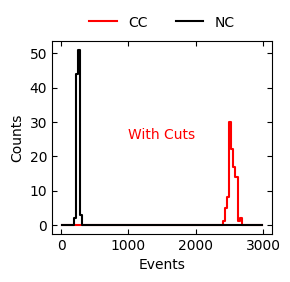

In [ ]:
# Let's plot it
# -----------------------------------------------------------
# plot
fig, ax = plt.subplots(1, 1, figsize=(3,3))

tmp_bins = np.linspace(0, 3000, 100)
tmp_centers = (tmp_bins[1:] + tmp_bins[:-1]) / 2

cc_binned, _ = np.histogram(results[2], bins=tmp_bins)
nc_binned, _ = np.histogram(results[0], bins=tmp_bins)

ax.step(
    tmp_centers,
    cc_binned,
    color='r',
    ls='-',
    label=r'CC'
)

ax.step(
    tmp_centers,
    nc_binned,
    color='k',
    ls='-',
    label=r'NC'
)

# ax.axvline(np.percentile(nc_ratios, 10), 0, 1e4, color='k')
# ax.fill_betweenx([0, 1e4], np.percentile(nc_ratios, 10), 5, color='k', alpha=0.2)

# ax.fill_betweenx([0, 1e5], 0, 1e0, color='k', alpha=0.2)
# -----------------------------------------------------------
# axis
# ax.set_xlim(0, 4)
# ax.set_ylim(0, 1e3)
ax.set_yscale('linear')
ax.set_xscale('linear')
# -----------------------------------------------------------
# legend
ax.legend(frameon=False, ncols=2, loc=9, bbox_to_anchor=(0.5, 1.2))
# -----------------------------------------------------------
# labels
ax.set_xlabel(r"Events")
ax.set_ylabel(r"Counts")
ax.text(1000, 25, "With Cuts", color='r')
ax.tick_params(axis='both', which='both', direction='in', right=True, top=True)
fig.tight_layout()
# fig.savefig('atmospheric_flux.pdf', bbox_inches='tight', dpi=500)

#### Exercise 9

This is all well and good, but this is not a usuable form of a simulation chain. Try to create your own simulation chain (improvements welcome!) based on the functions here and the example package provided. The basics are setup and can be tested in "basic_example.ipynb"